# Exploratory Data Analysis (EDA)

This script performs data checks, descriptive tables and the core visualizations required to understand the monthly Pulmonary Tuberculosis series (2001–2010) and to prepare inputs for time-series modeling and forecasting (2011 prediction).

## Step #1: Initiate environment for **Exploratory Data Analysis**
This section imports necessary libraries, creates debugging flags and control variables and configures paths.

In [46]:
# EN: Setup cell - imports, debug/lang flags, paths, and plotting defaults
# PT-BR: Célula de setup - imports, flags de debug/idioma, caminhos e defaults de plot

DEBUG = True        # EN: Show debug messages?  PT-BR: Mostrar mensagens de debug?
LANGUAGE = "EN"     # EN: "EN" or "PT"  PT-BR: "EN" ou "PT"

import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot defaults
plt.rcParams.update({"figure.figsize": (12, 5), "font.size": 12})
sns.set_style("whitegrid")

# Paths (adjust if needed)
DATA_DIR = Path("processed_data")
FIG_DIR = Path("figures")
TAB_DIR = Path("tables")
FIG_DIR.mkdir(exist_ok=True, parents=True)
TAB_DIR.mkdir(exist_ok=True, parents=True)

def debug(en_msg, pt_msg=""):
    if not DEBUG:
        return
    msg = en_msg if LANGUAGE.upper()=="EN" else (pt_msg if pt_msg else en_msg)
    print("[DEBUG]", msg)

debug("Setup completed. Data dir = processed_data/", "Setup completo. Pasta de dados = processed_data/")


[DEBUG] Setup completed. Data dir = processed_data/


### Step 2: **Load Data**
Load the preprocessed data for EDA.

In [47]:
# EN: Load core CSVs (already preprocessed)
# PT-BR: Carregar CSVs principais (já pré-processados)

fn_filtered = DATA_DIR / "filtered_pulmonary_tb_rows.csv"
fn_monthly = DATA_DIR / "monthly_pulmonary_tb_by_month.csv"
fn_annual = DATA_DIR / "annual_pulmonary_tb_by_year.csv"

for f in (fn_filtered, fn_monthly, fn_annual):
    if not f.exists():
        raise FileNotFoundError(f"Required file not found: {f} — check pre-processing step. / Arquivo necessário não encontrado: {f} — verifique pré-processamento.")

df_raw = pd.read_csv(fn_filtered, low_memory=False)
df_monthly = pd.read_csv(fn_monthly, parse_dates=["date"] if "date" in pd.read_csv(fn_monthly, nrows=0).columns else None)
df_annual = pd.read_csv(fn_annual)

debug(f"Loaded: filtered={len(df_raw)} rows, monthly={len(df_monthly)} rows, annual={len(df_annual)} rows",
    f"Carregados: filtrados={len(df_raw)} linhas, mensal={len(df_monthly)} linhas, anual={len(df_annual)} linhas")

# Quick peek
df_raw.head()


[DEBUG] Loaded: filtered=26211 rows, monthly=120 rows, annual=10 rows


,nu_notific,tp_not,id_agravo,dt_notific,nu_ano,sg_uf_not,id_municip,id_regiona,id_unidade,dt_diag,...,nu_comu_ex,situa_9_m,situa_12_m,situa_ence,dt_encerra,nu_lote_ia,date_parsed,year,month,cases_raw
0,19210,2.0,A169,2001-10-02,2001.0,21.0,210880.0,1432.0,2645696.0,2001-10-02,...,NaN,2.0,NaN,2.0,2002-02-04 00:00:00,2010001.0,2001-02-10,2001,2,0
1,28158,2.0,A169,2001-01-17,2001.0,21.0,211130.0,1430.0,2464276.0,2000-12-20,...,NaN,1.0,NaN,1.0,2001-07-26 00:00:00,2009022.0,2001-01-17,2001,1,0
2,28142,2.0,A169,2001-04-28,2001.0,21.0,211130.0,1430.0,2698021.0,2001-04-28,...,NaN,1.0,NaN,1.0,2001-10-30 00:00:00,2009022.0,2001-04-28,2001,4,0
3,33044,2.0,A169,2001-07-12,2001.0,21.0,211130.0,1430.0,2458292.0,2001-07-12,...,NaN,4.0,NaN,4.0,2004-10-08 00:00:00,2009022.0,2001-12-07,2001,12,0
4,27490,2.0,A169,2001-01-19,2001.0,21.0,211130.0,1430.0,2458292.0,2001-01-19,...,NaN,2.0,NaN,2.0,2001-05-19 00:00:00,2009022.0,2001-01-19,2001,1,0


### Step 3: **Check Data**
Check the loaded data for errors and inconsistencies.

In [48]:
# EN: Quick sanity checks: dtypes, missing counts, date parse validation
# PT-BR: Checagens rápidas: dtypes, contagem de missings, validação de data

def print_section(title_en, title_pt):
    if LANGUAGE.upper()=="EN":
        print(title_en)
    else:
        print(title_pt)

print_section("=== RAW ROWS: info() ===", "=== LINHAS FILTRADAS: info() ===")
display(df_raw.info())

print_section("\n=== MONTHLY: head() & dtypes ===", "\n=== MENSAL: head() & tipos ===")
display(df_monthly.head())
display(df_monthly.dtypes)

print_section("\n=== Missing values (raw) ===", "\n=== Valores faltantes (raw) ===")
display(df_raw.isna().sum().to_frame("missing_count").sort_values("missing_count", ascending=False).head(40))

print_section("\n=== Missing values (monthly) ===", "\n=== Valores faltantes (mensal) ===")
display(df_monthly.isna().sum().to_frame("missing_count").sort_values("missing_count", ascending=False))


=== RAW ROWS: info() ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26211 entries, 0 to 26210
Columns: 106 entries, nu_notific to cases_raw
dtypes: float64(74), int64(7), object(25)
memory usage: 21.2+ MB


None


=== MONTHLY: head() & dtypes ===


,year,month,cases,date
0,2001,1,236,2001-01-01
1,2001,2,174,2001-02-01
2,2001,3,219,2001-03-01
3,2001,4,178,2001-04-01
4,2001,5,295,2001-05-01


year              int64
month             int64
cases             int64
date     datetime64[ns]
dtype: object


=== Missing values (raw) ===


,missing_count
dt_transdm,26211
dt_transrm,26211
id_geo2,26211
extrapul_o,26211
id_geo1,26194
situa_12_m,26140
dt_transus,26036
id_cns_sus,26026
id_logrado,25833
agravoutde,25754



=== Missing values (monthly) ===


,missing_count
year,0
month,0
cases,0
date,0


In [49]:
# EN: Ensure 'date' is datetime and set monthly index; compute basic descriptive stats for monthly series
# PT-BR: Garantir que 'date' é datetime e definir index mensal; calcular estatísticas descritivas básicas

# Ensure date column:
if "date" in df_monthly.columns:
    df_monthly["date"] = pd.to_datetime(df_monthly["date"], errors="coerce")
else:
    # fallback: construct date if year/month columns exist
    if "year" in df_monthly.columns and "month" in df_monthly.columns:
        df_monthly["date"] = pd.to_datetime(df_monthly["year"].astype(str) + "-" + df_monthly["month"].astype(str) + "-01", errors="coerce")
    else:
        raise SystemExit("Monthly CSV lacks 'date' and no year/month columns — cannot proceed. / CSV mensal não tem 'date' nem year/month — não é possível prosseguir.")

# Set index
df_monthly = df_monthly.sort_values("date").set_index("date")
series = df_monthly["cases"].astype(float)

# Basic stats
stats = series.describe().to_frame().T
stats["cv"] = stats["std"] / stats["mean"]
stats = stats[["count","mean","std","min","25%","50%","75%","max","cv"]]
stats = stats.rename(columns={"50%":"median"})
print_section("Monthly series descriptive statistics:", "Estatísticas descritivas da série mensal:")
display(stats.T)

# Save table
stats.to_csv(TAB_DIR / "monthly_series_descriptive_stats.csv", index=False)
debug("Saved monthly descriptive stats table.", "Estatísticas mensais salvas.")

Monthly series descriptive statistics:


,cases
count,120.000000
mean,218.166667
std,32.559792
min,133.000000
25%,194.500000
median,220.000000
75%,236.250000
max,298.000000
cv,0.149243


[DEBUG] Saved monthly descriptive stats table.


[DEBUG] Saved time series plot to figures\ts_monthly_cases_line.png


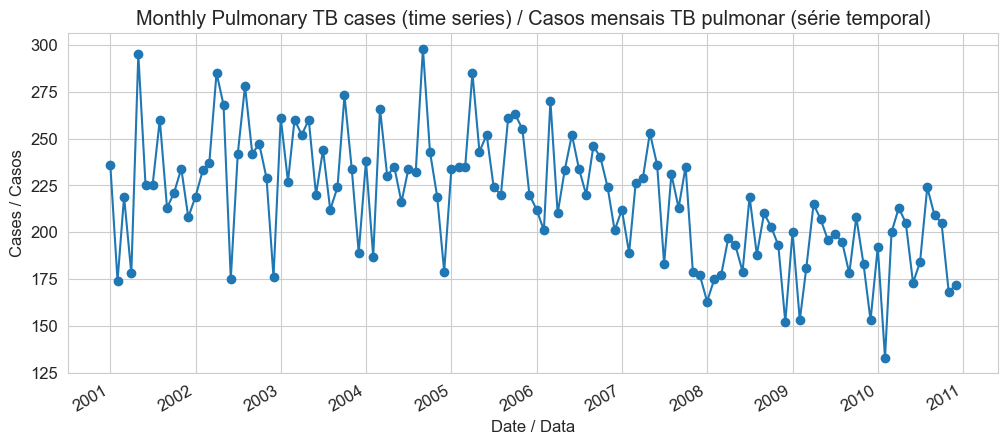

In [50]:
# EN: Plot monthly time series (line) and save figure
# PT-BR: Plot da série mensal (linha) e salvar figura

fig, ax = plt.subplots()
ax.plot(series.index, series.values, marker='o', linestyle='-')
ax.set_title("Monthly Pulmonary TB cases (time series) / Casos mensais TB pulmonar (série temporal)")
ax.set_xlabel("Date / Data")
ax.set_ylabel("Cases / Casos")
ax.grid(True)
fig.autofmt_xdate()
fig_path = FIG_DIR / "ts_monthly_cases_line.png"
fig.savefig(fig_path, bbox_inches="tight", dpi=150)
debug(f"Saved time series plot to {fig_path}", f"Plot da série salvo em {fig_path}")
plt.show()

[DEBUG] Saved month-wise boxplot to figures\boxplot_month_by_month.png


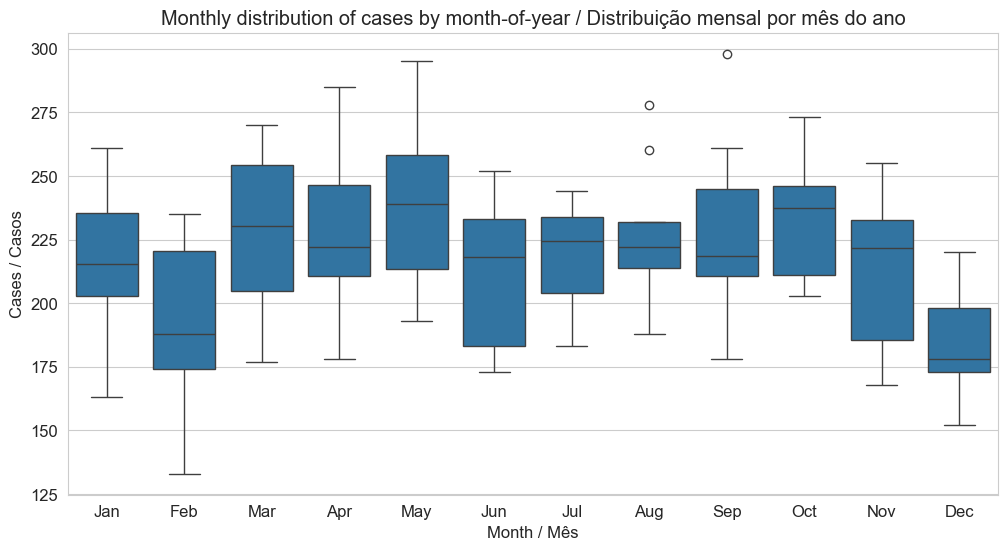

In [51]:
# EN: Boxplot by month to spot seasonality (month-of-year)
# PT-BR: Boxplot por mês para identificar sazonalidade (mês do ano)

df_monthly_plot = df_monthly.reset_index()
df_monthly_plot["month_num"] = df_monthly_plot["date"].dt.month
month_order = list(range(1,13))

plt.figure(figsize=(12,6))
sns.boxplot(x="month_num", y="cases", data=df_monthly_plot, order=month_order)
plt.title("Monthly distribution of cases by month-of-year / Distribuição mensal por mês do ano")
plt.xlabel("Month / Mês")
plt.ylabel("Cases / Casos")
plt.xticks(ticks=np.arange(12), labels=["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"])
box_path = FIG_DIR / "boxplot_month_by_month.png"
plt.savefig(box_path, bbox_inches="tight", dpi=150)
debug(f"Saved month-wise boxplot to {box_path}", f"Boxplot mensal salvo em {box_path}")
plt.show()

[DEBUG] Saved heatmap to figures\heatmap_year_month_cases.png


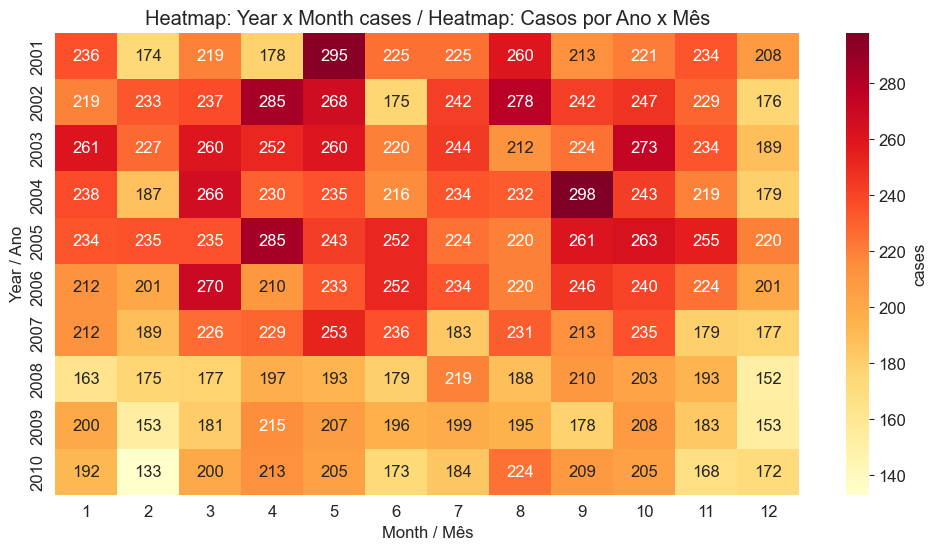

[DEBUG] Saved pivot table year-month to tables.


In [52]:
# EN: Heatmap (years x months) to visualize patterns across years and months
# PT-BR: Heatmap (anos x meses) para visualizar padrões ao longo dos anos e meses

pivot = df_monthly_plot.pivot_table(index=df_monthly_plot["date"].dt.year, columns=df_monthly_plot["date"].dt.month, values="cases", aggfunc="sum")
pivot = pivot.reindex(index=sorted(pivot.index), columns=month_order)

plt.figure(figsize=(12,6))
sns.heatmap(pivot, annot=True, fmt=".0f", cmap="YlOrRd", cbar_kws={'label':'cases'})
plt.title("Heatmap: Year x Month cases / Heatmap: Casos por Ano x Mês")
plt.xlabel("Month / Mês")
plt.ylabel("Year / Ano")
heat_path = FIG_DIR / "heatmap_year_month_cases.png"
plt.savefig(heat_path, bbox_inches="tight", dpi=150)
debug(f"Saved heatmap to {heat_path}", f"Heatmap salvo em {heat_path}")
plt.show()

# Save pivot table for reference
pivot.to_csv(TAB_DIR / "pivot_year_month_cases.csv")
debug("Saved pivot table year-month to tables.", "Pivot ano-mes salvo em tables.")

[DEBUG] Saved histogram to figures\histogram_monthly_cases.png


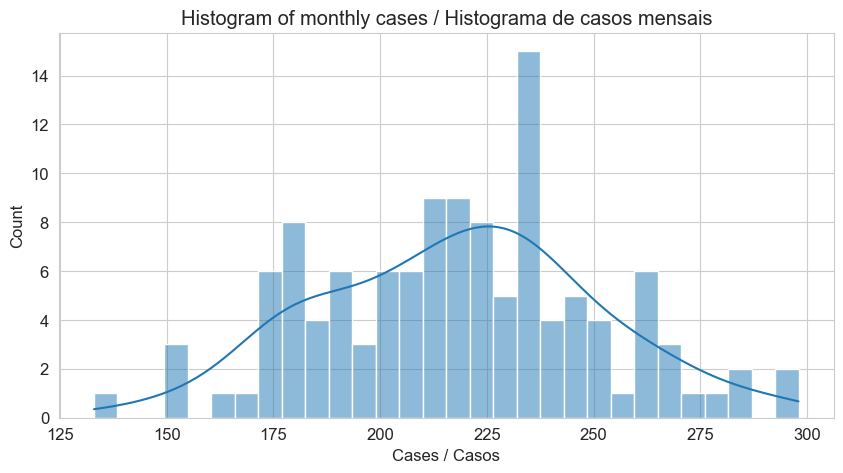

In [53]:
# EN: Histogram and KDE for monthly counts
# PT-BR: Histograma e KDE para contagem mensal

plt.figure(figsize=(10,5))
sns.histplot(series.dropna(), kde=True, bins=30)
plt.title("Histogram of monthly cases / Histograma de casos mensais")
plt.xlabel("Cases / Casos")
hist_path = FIG_DIR / "histogram_monthly_cases.png"
plt.savefig(hist_path, bbox_inches="tight", dpi=150)
debug(f"Saved histogram to {hist_path}", f"Histograma salvo em {hist_path}")
plt.show()

[DEBUG] Saved STL decomposition to figures\stl_decomposition.png


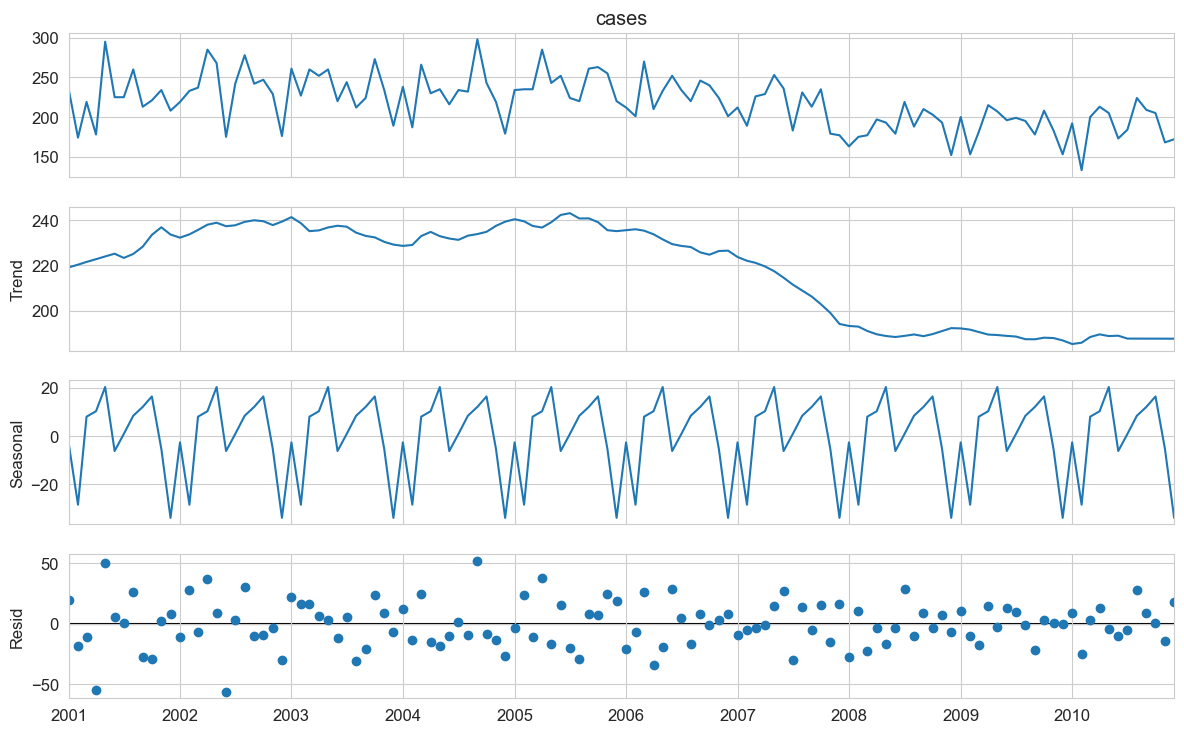

In [54]:
# EN: STL decomposition (trend, seasonal, resid). Period=12 for monthly seasonality.
# PT-BR: Decomposição STL (tendência, sazonal, resíduo). Período=12 para sazonalidade mensal.

try:
    decomposition = seasonal_decompose(series.dropna(), model='additive', period=12, extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(12,8)
    stl_path = FIG_DIR / "stl_decomposition.png"
    fig.savefig(stl_path, bbox_inches="tight", dpi=150)
    debug(f"Saved STL decomposition to {stl_path}", f"Decomposição STL salva em {stl_path}")
    plt.show()
except Exception as e:
    debug(f"STL decomposition failed: {e}", f"Decomposição STL falhou: {e}")
    print("STL decomposition failed — likely too few data points or NaNs. / Falha na decomposição STL — provavelmente poucos pontos ou NaNs.")

[DEBUG] Saved ACF plot to figures\acf_monthly.png


<Figure size 1200x400 with 0 Axes>

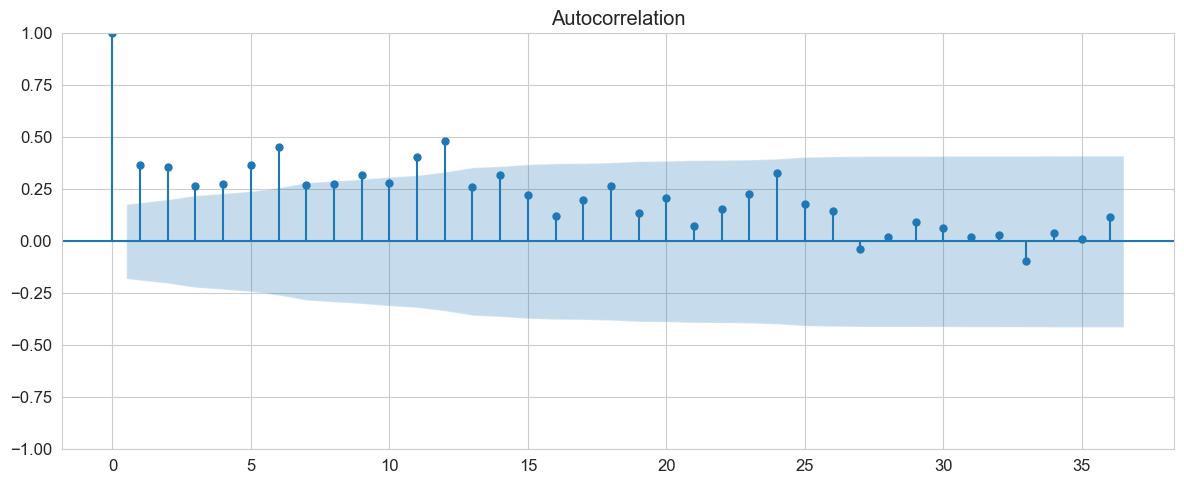

[DEBUG] Saved PACF plot to figures\pacf_monthly.png


<Figure size 1200x400 with 0 Axes>

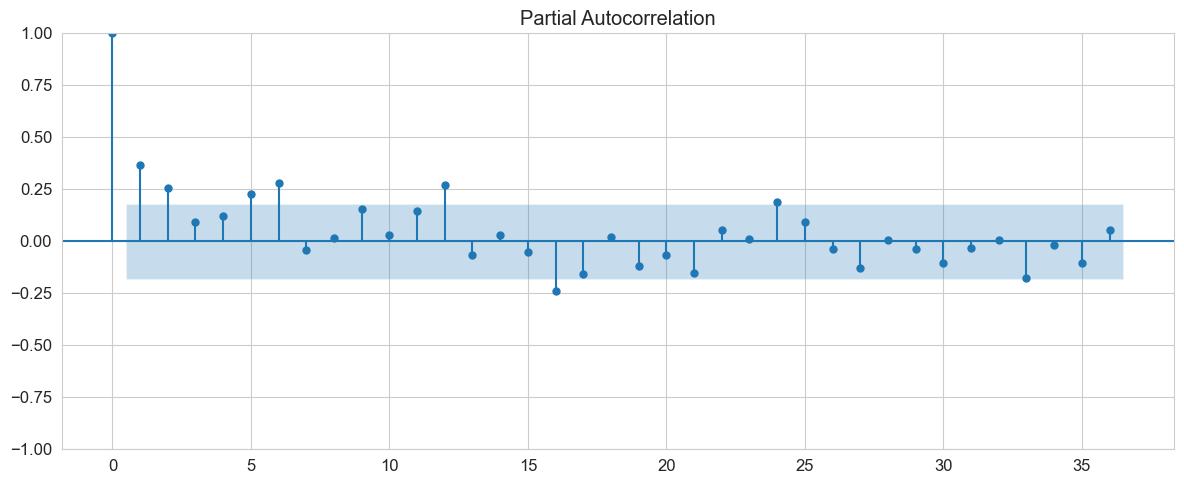

In [55]:
# EN: Plot ACF and PACF to inspect autocorrelation and help choose ARIMA orders
# PT-BR: Plot ACF e PACF para inspecionar autocorrelação e ajudar a escolher ordens ARIMA

plt.figure(figsize=(12,4))
plot_acf(series.dropna(), lags=36)
plt.tight_layout()
acf_path = FIG_DIR / "acf_monthly.png"
plt.savefig(acf_path, bbox_inches="tight", dpi=150)
debug(f"Saved ACF plot to {acf_path}", f"ACF salvo em {acf_path}")
plt.show()

plt.figure(figsize=(12,4))
plot_pacf(series.dropna(), lags=36, method='ywm')
plt.tight_layout()
pacf_path = FIG_DIR / "pacf_monthly.png"
plt.savefig(pacf_path, bbox_inches="tight", dpi=150)
debug(f"Saved PACF plot to {pacf_path}", f"PACF salvo em {pacf_path}")
plt.show()

In [56]:
# EN: Yearly aggregated table and year-on-year percent change
# PT-BR: Tabela agregada anual e variação percentual ano-a-ano

if "cases" in df_annual.columns:
    df_annual_sorted = df_annual.sort_values("year").copy()
else:
    # fallback: aggregate from monthly
    df_annual_sorted = df_monthly_plot.groupby(df_monthly_plot["date"].dt.year)["cases"].sum().reset_index().rename(columns={"date":"year"})

df_annual_sorted["pct_change"] = df_annual_sorted["cases"].pct_change() * 100
display(df_annual_sorted)
df_annual_sorted.to_csv(TAB_DIR / "annual_summary_cases_pctchange.csv", index=False)
debug("Saved annual summary table.", "Resumo anual salvo.")

,year,cases,population,incidence_per_100k,pct_change
0,2001,50266,NaN,NaN,NaN
1,2002,395140,NaN,NaN,686.097959
2,2003,501459,NaN,NaN,26.906666
3,2004,469697,NaN,NaN,-6.333918
4,2005,516799,NaN,NaN,10.028167
5,2006,459628,NaN,NaN,-11.062521
6,2007,693293,NaN,NaN,50.837851
7,2008,403975,NaN,NaN,-41.730985
8,2009,311683,NaN,NaN,-22.845968
9,2010,331407,NaN,NaN,6.328225


[DEBUG] Saved annual summary table.


In [57]:
# EN: Save compact EDA summary for later use (quick tables)
# PT-BR: Salvar um resumo EDA compacto para uso posterior

# Monthly seasonal means
seasonal_means = df_monthly_plot.groupby(df_monthly_plot["date"].dt.month)["cases"].mean().rename_axis("month").reset_index()
seasonal_means["month_name"] = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
seasonal_means.to_csv(TAB_DIR / "monthly_seasonal_means.csv", index=False)

# Top months (highest counts)
top_months = df_monthly_plot.sort_values("cases", ascending=False).head(20)
top_months.to_csv(TAB_DIR / "top_20_months_by_cases.csv", index=False)

debug("Saved seasonal means and top months tables.", "Salvo médias sazonais e top meses.")

[DEBUG] Saved seasonal means and top months tables.


## First insights — EN / PT-BR

**EN (short):**
- Check the time series plot for long-term trend and for obvious spikes.
- Boxplot by month shows whether a consistent seasonality exists (same months high each year).
- Heatmap helps spot anomalous years or months.
- Use STL decomposition and ACF/PACF to choose candidate models (SARIMA orders).
- Save figures and tables in `figures/` and `tables/` for the report.

**PT-BR (curto):**
- Observe na série temporal a tendência e picos evidentes.
- O boxplot por mês mostra se há sazonalidade consistente (meses com picos repetidos).
- O heatmap ajuda a detectar anos/mês atípicos.
- Use a decomposição STL e ACF/PACF para escolher modelos candidatos (ordens SARIMA).
- As figuras e tabelas foram salvas em `figures/` e `tables/` para uso no relatório.

In [58]:
# EN: Optional - list generated files
# PT-BR: Opcional - listar arquivos gerados

print("Figures saved to:", FIG_DIR.resolve())
print("Tables saved to:", TAB_DIR.resolve())
print("Files in figures (example):", [p.name for p in sorted(FIG_DIR.glob("*.png"))][:10])
print("Files in tables (example):", [p.name for p in sorted(TAB_DIR.glob("*.csv"))][:20])

Figures saved to: D:\OneDrive\Arquivos\Pessoais\Desenvolvimento\Ciência de Dados\IC2011 - TB MA\figures
Tables saved to: D:\OneDrive\Arquivos\Pessoais\Desenvolvimento\Ciência de Dados\IC2011 - TB MA\tables
Files in figures (example): ['acf_monthly.png', 'boxplot_month_by_month.png', 'heatmap_year_month_cases.png', 'histogram_monthly_cases.png', 'pacf_monthly.png', 'stl_decomposition.png', 'ts_monthly_cases_line.png']
Files in tables (example): ['annual_summary_cases_pctchange.csv', 'monthly_seasonal_means.csv', 'monthly_series_descriptive_stats.csv', 'pivot_year_month_cases.csv', 'top_20_months_by_cases.csv']
